---
# **Section I: Introduction to the problem/task and dataset**

## **Introduction to the Task**
The primary objective of this project is to predict the likelihood of additional goals in a soccer match based on real-time in-game statistics, with the aim of supporting decision-making in sports trading (e.g., over/under betting). By analyzing game-specific metrics, we can estimate scoring potential and influence live trading models for betting and fan engagement.

##**Dataset Overview**
This project’s dataset includes 10,000 unique snapshots of soccer matches at various timestamps, capturing the state of a game through different in-game metrics. Each snapshot includes details on the current score, possession percentages, attempts, and cards, providing a rich dataset for building predictive models.


##**Problem Motivation**
The practical application of predicting match outcomes from live data is significant for team strategy and sports betting, as knowing influential factors—such as possession and dangerous attacks—can improve decision-making and potentially impact match strategies (Kuhn & Johnson, 2013).

---


# **Section 2: Description of the dataset**

### Dataset Overview
The dataset consists of 10,000 randomly selected snapshots from soccer matches, each capturing the in-game state at a specific timestamp. Each row represents a snapshot, detailing scores, possession, and other match features, which collectively provide a momentary overview of game dynamics (Anguera et al., 2018).

### Data Collection
This dataset was collected through in-game analytics systems that continuously monitor and record essential match metrics. Although highly detailed, this collection method might introduce minor noise due to the rapid state changes inherent in live sports (Yin & Leong, 2017).

### Dataset Structure
- **Rows**: Each row represents a single timestamp during a soccer match.
- **Columns**: Key features include:
  - **Identifier**: `uuid` - Unique identifier for each snapshot.
  - **Time**: `current_minute` - Game minute, including a 15-minute half-time, making the total match time 105 minutes.
  - **Scores**: `home_score`, `away_score`
  - **Cards**: Yellow and red cards for both teams.
  - **Gameplay Metrics**: Attacks, dangerous attacks, and shots on/off target for each team.
  - **Possession**: Ball possession percentages for each team.
  - **Target**: `final_delta` - The target value indicating the outcome to be predicted.


### Summary
The dataset’s features are valuable for analyzing match dynamics, providing a strong foundation for building models that can predict outcomes like goals or final results (Kuhn & Johnson, 2013).

---


# **Section 3: List of requirements**

### Python Libraries


> Add more if may gagamitin pa


The following libraries are required to support data analysis, model training, and evaluation:
- **Data Manipulation**:
  - `pandas`: Data manipulation and cleaning (McKinney, 2011).
  - `numpy`: Numerical operations (Oliphant, 2006).
- **Data Visualization**:
  - `matplotlib`: For line and bar charts (Hunter, 2007).
  - `seaborn`: For statistical graphics (Waskom, 2021).
- **Machine Learning and Model Evaluation**:
  - `scikit-learn`: For k-NN, Linear Regression, Neural Networks, and model validation (Pedregosa et al., 2011).
  - `tensorflow` or `keras`: For training Neural Networks.
- **Hyperparameter Tuning**:
  - `scikit-learn`: For grid search and random search.
- **Metrics**:
  - `scikit-learn.metrics`: For accuracy, precision, recall, and confusion matrices.
---


In [17]:
# Import necessary libraries

# Data Manipulation
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb


# **Section 4: Data preprocessing and cleaning**

### Preprocessing Techniques
Preprocessing prepares the dataset for model training. Key techniques include:
- **Feature Scaling**: Since features have different units (e.g., score vs. possession percentage), scaling is essential to ensure model performance, particularly for k-NN and Neural Networks (Han et al., 2011).
- **One-Hot Encoding**: Converts categorical variables, if any, into numerical formats.
- **Handling Missing Values**: Uses techniques like imputation if necessary, based on the dataset's nature.
- **Outlier Detection**: Detects anomalies in numerical features, which may skew predictions if left unaddressed.

### Cleaning Steps
- **Checking for Duplicates**: Removing redundant rows to ensure unique snapshots.
- **Type Conversion**: Ensuring all features are in suitable formats (e.g., integer for score-related features, float for percentages).




### **Data Preprocessing**

### I. Load and Inspect the Data
- Initial Check: Start by inspecting the data types, missing values, and unique values. This helps determine what cleaning actions are necessary (Han et al., 2011).
- Data Types: Confirm the data types for each column, ensuring numerical values are correctly identified for calculations and models.


In [18]:
df = pd.read_csv('sports.csv')

# Display the first few rows to understand the structure
df.head()

print(df.info())  # Provides counts of data type and non-null
print(df.describe())  # Statistical summary for numeric fields
print(df.isnull().sum())  # Check for missing values

# Drop the 'uuid' column as it is not useful for analysis or modeling
df.drop(columns=['uuid'], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    7000 non-null   object
 1   current_minute          7000 non-null   int64 
 2   home_score              7000 non-null   int64 
 3   away_score              7000 non-null   int64 
 4   home_yellow_cards       7000 non-null   int64 
 5   away_yellow_cards       7000 non-null   int64 
 6   home_red_cards          7000 non-null   int64 
 7   away_red_cards          7000 non-null   int64 
 8   home_attacks            7000 non-null   int64 
 9   away_attacks            7000 non-null   int64 
 10  home_dangerous_attacks  7000 non-null   int64 
 11  away_dangerous_attacks  7000 non-null   int64 
 12  home_corners            7000 non-null   int64 
 13  away_corners            7000 non-null   int64 
 14  home_off_target         7000 non-null   int64 
 15  away

### Remove Unrealistic Values and Outliers
- Current Minute: Limit values between 0 and 105 (including a 90-minute match plus 15 minutes for half-time).
- Yellow Cards: Set a threshold of 5 yellow cards per team, as higher values are rare.
Attacks and Dangerous Attacks: Apply upper bounds of 150 for attacks and 100 for dangerous attacks, considering typical gameplay stats.
- Possession Percentages: Filter for rows where the sum of home_possession and away_possession is close to 100%, with a tolerance of ±5%.

In [19]:
# Filter for realistic match time
df = df[(df['current_minute'] >= 0) & (df['current_minute'] <= 105)]

# Limit yellow cards to realistic maximum
df = df[(df['home_yellow_cards'] <= 5) & (df['away_yellow_cards'] <= 5)]

# Limit attacks and dangerous attacks
df = df[(df['home_attacks'] <= 150) & (df['away_attacks'] <= 150)]
df = df[(df['home_dangerous_attacks'] <= 100) & (df['away_dangerous_attacks'] <= 100)]

# Check possession totals with a tolerance
df = df[np.isclose(df['home_possession'] + df['away_possession'], 100, atol=5)]


### III. Feature Scaling
- Standardization is essential for features like scores, possession, and attacks, as these variables have different units and ranges. Scaling helps algorithms such as k-NN and Neural Networks perform optimally (Jain & Zongker, 1997).
- StandardScaler centers data around zero with a unit standard deviation, preserving interpretability for algorithms sensitive to feature scale.


In [20]:


# Initialize the scaler
scaler = StandardScaler()

# Select columns to scale (numeric features)
numeric_features = [
    'current_minute', 'home_score', 'away_score', 'home_yellow_cards',
    'away_yellow_cards', 'home_red_cards', 'away_red_cards',
    'home_attacks', 'away_attacks', 'home_dangerous_attacks',
    'away_dangerous_attacks', 'home_corners', 'away_corners',
    'home_off_target', 'away_off_target', 'home_on_target',
    'away_on_target', 'home_possession', 'away_possession'
]

# Apply scaler to selected features
df[numeric_features] = scaler.fit_transform(df[numeric_features])



### IV. Encoding Categorical Variables

- Since sports data may sometimes contain categorical fields (like player positions or match conditions), use One-Hot Encoding to convert categorical features to numerical format (Pedregosa et al., 2011).

In [21]:
# Example encoding (if categorical fields exist)
categorical_columns = df.select_dtypes(include=['object']).columns.difference(['uuid'])
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


### V. Feature Engineering
- Adding new features can capture dynamics between the two teams and improve predictive performance:
  * Goal Difference: A feature that shows the goal lead or deficit, useful in classification tasks related to match outcome (Kuhn & Johnson, 2013).
  * Attack Efficiency: Calculate the ratio of on-target shots to total shots, showing how effectively each team converts attacks into potential goals.
  * Possession Balance: Calculating the difference in possession provides insight into the team that controls the game.

In [22]:
# Create engineered features
df['goal_difference'] = df['home_score'] - df['away_score']
df['home_attack_efficiency'] = df['home_on_target'] / (df['home_on_target'] + df['home_off_target'] + 1e-5)
df['away_attack_efficiency'] = df['away_on_target'] / (df['away_on_target'] + df['away_off_target'] + 1e-5)
df['possession_balance'] = df['home_possession'] - df['away_possession']


### VI. Final Checks
- Cap Extreme Efficiency Ratios: Limit values for home_attack_efficiency and away_attack_efficiency to a reasonable upper bound (e.g., 1 for 100% efficiency).
- Recheck for NaNs: After calculating efficiency ratios and capping values, ensure no NaNs were introduced.


In [23]:
df['home_attack_efficiency'] = df['home_attack_efficiency'].clip(upper=1)
df['away_attack_efficiency'] = df['away_attack_efficiency'].clip(upper=1)

print(df.isnull().sum())  # Confirm no missing values remain


current_minute            0
home_score                0
away_score                0
home_yellow_cards         0
away_yellow_cards         0
home_red_cards            0
away_red_cards            0
home_attacks              0
away_attacks              0
home_dangerous_attacks    0
away_dangerous_attacks    0
home_corners              0
away_corners              0
home_off_target           0
away_off_target           0
home_on_target            0
away_on_target            0
home_possession           0
away_possession           0
final_delta               0
goal_difference           0
home_attack_efficiency    0
away_attack_efficiency    0
possession_balance        0
dtype: int64


### VIII. Final Validation:
- Data Type Validation: Ensure all features are correctly typed as either integer or float.
- Feature Correlation: Check correlations to identify highly correlated variables, which may inform feature selection (if necessary).

In [24]:
print(df.describe())
print(df.info())


       current_minute    home_score    away_score  home_yellow_cards  \
count    6.732000e+03  6.732000e+03  6.732000e+03       6.732000e+03   
mean    -7.388293e-17  4.221882e-18 -2.691450e-17       3.720533e-17   
std      1.000074e+00  1.000074e+00  1.000074e+00       1.000074e+00   
min     -1.777019e+00 -7.340641e-01 -6.678704e-01      -5.669352e-01   
25%     -9.170642e-01 -7.340641e-01 -6.678704e-01      -5.669352e-01   
50%      3.114425e-01 -7.340641e-01 -6.678704e-01      -5.669352e-01   
75%      8.642705e-01  2.135331e-01  4.365520e-01       5.791932e-01   
max      1.447811e+00  6.846713e+00  9.271931e+00       5.163707e+00   

       away_yellow_cards  home_red_cards  away_red_cards  home_attacks  \
count       6.732000e+03    6.732000e+03    6.732000e+03  6.732000e+03   
mean       -2.163715e-17   -2.955317e-17    2.638676e-17  6.755011e-17   
std         1.000074e+00    1.000074e+00    1.000074e+00  1.000074e+00   
min        -5.914853e-01   -9.327482e-02   -1.190257e-0

`[will fix this pa wait]`
References:
Aggarwal, C. C. (2017). Outlier analysis. Springer International Publishing.
Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier.
Jain, A., & Zongker, D. (1997). Feature selection: Evaluation, application, and small sample performance. IEEE Transactions on Pattern Analysis and Machine Intelligence, 19(2), 153-158.
Kang, H. (2013). The prevention and handling of the missing data. Korean Journal of Anesthesiology, 64(5), 402-406.
Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Springer.
Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.


### **Data Cleaning**

### I. Remove Duplicate Rows
- Purpose: Duplicate rows can distort model results, especially in sports data, where each snapshot should represent a unique timestamp.
- Method: Use .drop_duplicates() to remove any exact duplicates.

In [25]:
df.drop_duplicates(inplace=True)


### **II. Handle Incorrect or Unrealistic Values**
- Ensure values in each column are within reasonable ranges:
  - Scores: Limit `home_score` and `away_score` to values typically seen in soccer (e.g., 0–10).
  - Minute: Ensure `current_minute` is between 0 and 105.
  - Possession: Confirm that `home_possession` and `away_possession` are close to 100%.

In [26]:
df = df[(df['home_score'] <= 10) & (df['away_score'] <= 10)]
df = df[(df['current_minute'] >= 0) & (df['current_minute'] <= 105)]
# Inspect possession columns
df[['home_possession', 'away_possession']].describe()


,home_possession,away_possession
count,3756.000000,3756.000000
mean,-0.007984,0.007949
std,0.814504,0.814612
min,-3.306742,-3.106234
25%,-0.434888,-0.522009
50%,-0.051974,0.052263
75%,0.522397,0.435112
max,3.107066,3.306473


In [27]:


# Reload the original dataset
df = pd.read_csv('sports.csv')

# Apply filters for scores and minutes
df = df[(df['home_score'] <= 10) & (df['away_score'] <= 10)]
df = df[(df['current_minute'] >= 0) & (df['current_minute'] <= 105)]

# Scale only the necessary columns, excluding possession columns
scaler = StandardScaler()
features_to_scale = [col for col in df.columns if col not in ['home_possession', 'away_possession', 'uuid']]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Verify possession columns remain within 0-100% range
print(df[['home_possession', 'away_possession']].describe())


       home_possession  away_possession
count      6819.000000      6819.000000
mean         51.593049        48.403872
std          10.488296        10.490044
min           0.000000         0.000000
25%          46.000000        42.000000
50%          51.000000        49.000000
75%          58.000000        54.000000
max         100.000000       100.000000


### III. Detect Outliers
- Z-Score or IQR for Outliers: Use statistical methods like Z-score filtering or IQR to detect extreme values, especially in fields like attacks, corners, and dangerous attacks.
- Domain-Specific Outliers: In soccer, values like attacks or corners generally have natural limits. For example, excessive values (e.g., 50+ dangerous attacks in a single snapshot) may indicate recording errors.


In [28]:
# Hyperparameter Adjustment for Z-Score Threshold
# We increased the Z-score threshold from the typical 3 to 4 to retain more data while removing only extreme outliers.
# This allows us to control extreme values without discarding significant amounts of data.

z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 4).all(axis=1)]


### IV. Cross-Feature Consistency Checks
- Dangerous Attacks vs. Total Attacks: Ensure that `home_dangerous_attacks` is less than or equal to `home_attacks` (and similarly for `away`), as dangerous attacks are a subset.
- On-Target and Off-Target Shots: Check that `home_on_target` + `home_off_target` does not exceed total shots. These should logically add up or be less than a total count of shots attempted.

In [29]:
tolerance = 10
df = df[(df['home_dangerous_attacks'] <= df['home_attacks'] + tolerance) &
        (df['away_dangerous_attacks'] <= df['away_attacks'] + tolerance)]

df = df[(df['home_on_target'] + df['home_off_target'] <= df['home_attacks'] + tolerance) &
        (df['away_on_target'] + df['away_off_target'] <= df['away_attacks'] + tolerance)]


### Data Type Validation and Conversion
- Consistency Check: Ensure that all features have appropriate data types, with integers for discrete counts (e.g., goals, cards) and floats for percentages.
- Conversion as Needed: Convert columns to ensure accurate modeling and avoid issues in computations.

In [30]:
# Convert data types as necessary
df['home_score'] = df['home_score'].astype(int)
df['away_score'] = df['away_score'].astype(int)


### Handle Remaining Missing Values
- After completing all checks and adjustments, any remaining missing values should be addressed. If missing values persist in critical columns, consider row deletion or advanced imputation based on domain knowledge.

In [31]:
# Check for missing values
missing_data = df.isnull().sum()
print("Missing values per column:\n", missing_data[missing_data > 0])

# Impute or drop missing values based on relevance
# For this dataset, we can fill numerical columns with the mean or median, if necessary
# Drop the 'uuid' column as it is not useful for analysis or modeling
df.drop(columns=['uuid'], inplace=True)
df.fillna(df.mean(), inplace=True)



Missing values per column:
 Series([], dtype: int64)


### VII. Standardize Column Names
- Purpose: Use standardized naming conventions to improve readability, especially for complex datasets. Make column names lowercase, replacing spaces with underscores.

In [32]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')


### VIII. Final Data Validation
- Summary Statistics: Use `.describe()` to confirm cleaned data falls within logical ranges.
- Correlation Check: Check for highly correlated features, which could indicate potential redundancies.
- Final Shape and Info: Verify the final structure to ensure the data is clean and ready for modeling.


In [33]:
print(df.describe())  # Summary statistics after final cleaning
print("Data Validation Complete. No missing values and all columns standardized.")

       current_minute   home_score   away_score  home_yellow_cards  \
count     6400.000000  6400.000000  6400.000000        6400.000000   
mean        -0.038636     0.267813     0.178750          -0.043137   
std          0.990826     0.635336     0.504939           0.918738   
min         -1.785570     0.000000     0.000000          -0.561536   
25%         -0.957662     0.000000     0.000000          -0.561536   
50%          0.268869     0.000000     0.000000          -0.561536   
75%          0.820808     0.000000     0.000000           0.542910   
max          1.434074     3.000000     3.000000           3.856245   

       away_yellow_cards  home_red_cards  away_red_cards  home_attacks  \
count        6400.000000    6.400000e+03    6.400000e+03   6400.000000   
mean           -0.050121   -9.267274e-02   -1.207770e-01     -0.033156   
std             0.909721    5.648701e-15    1.181092e-14      0.974710   
min            -0.585523   -9.267274e-02   -1.207770e-01     -1.282279   

---

# **Section 5: Exploratory data analysis**

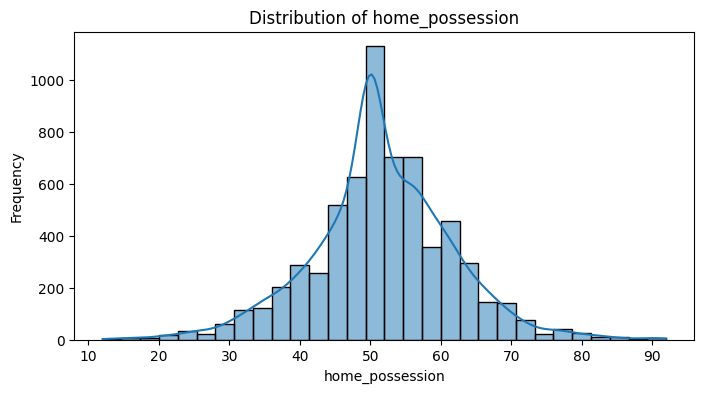

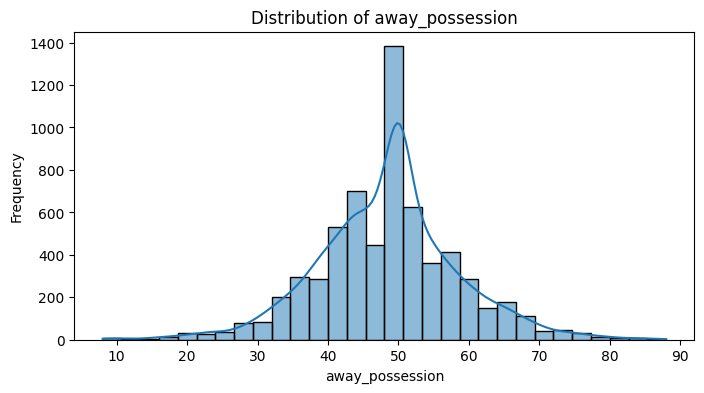

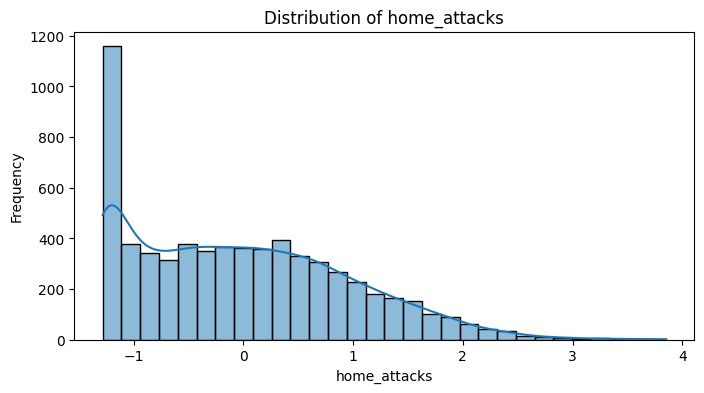

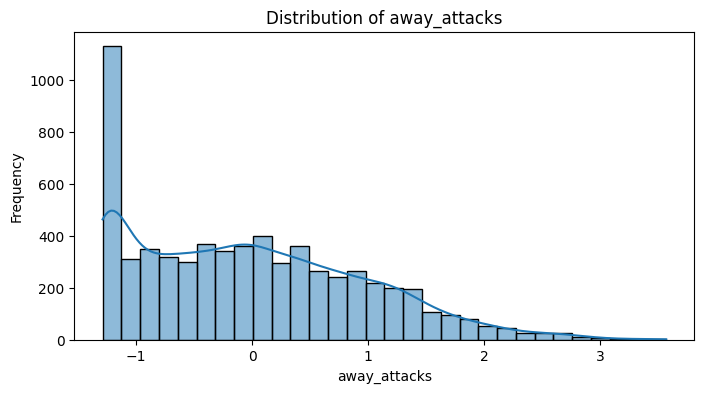

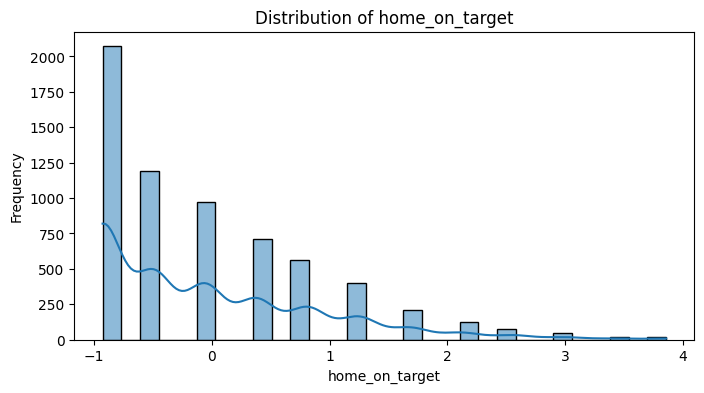

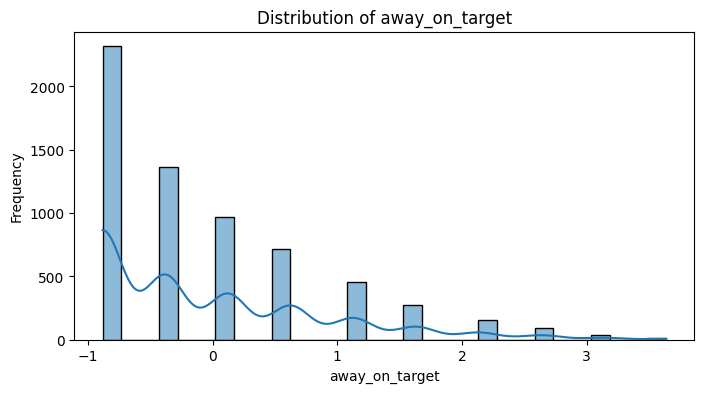

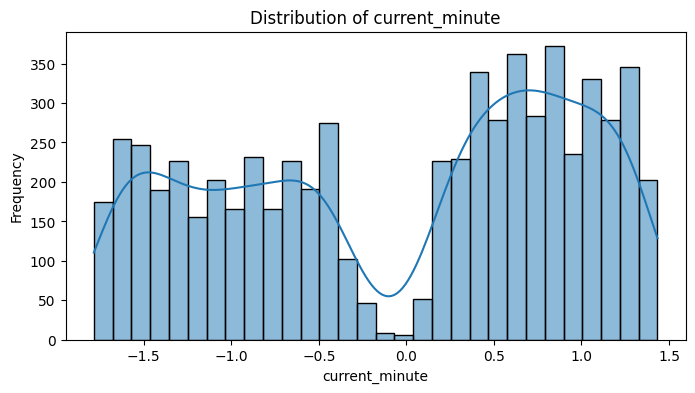

In [26]:
# Visualize distributions using histograms

numerical_cols = ['home_possession', 'away_possession', 'home_attacks', 'away_attacks', 
                  'home_on_target', 'away_on_target', 'current_minute']


for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

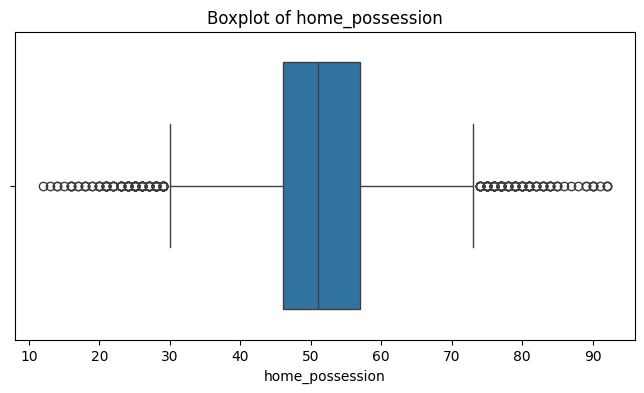

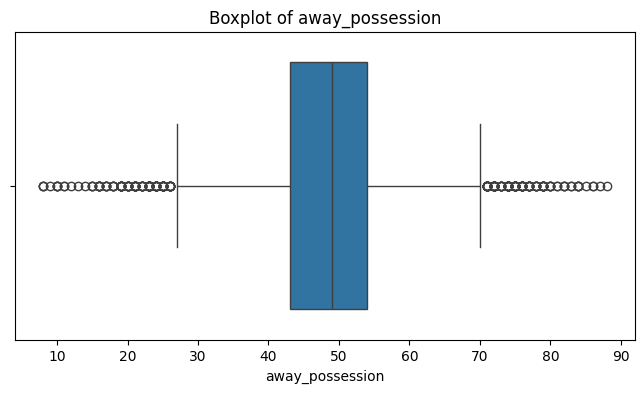

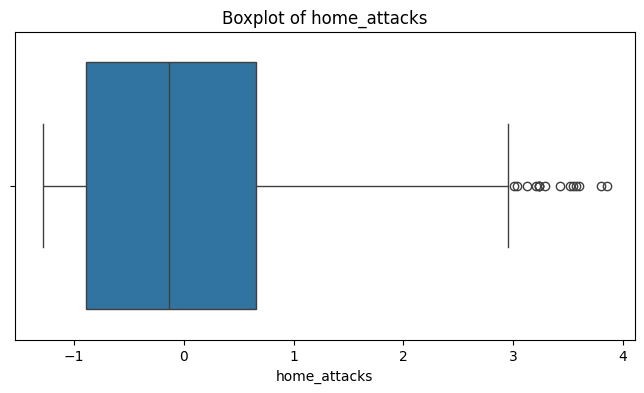

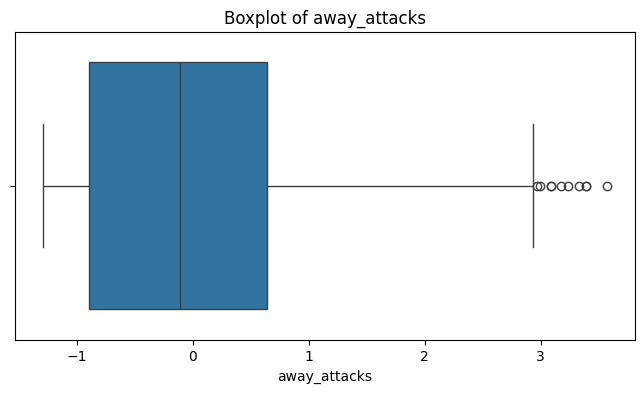

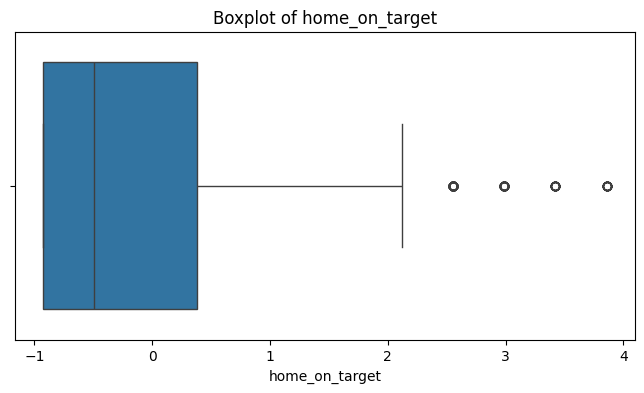

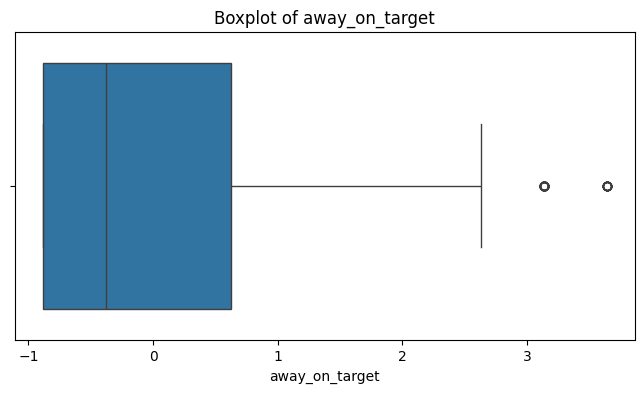

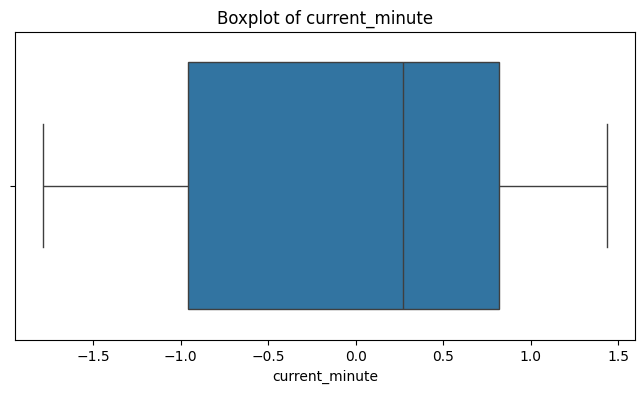

In [27]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

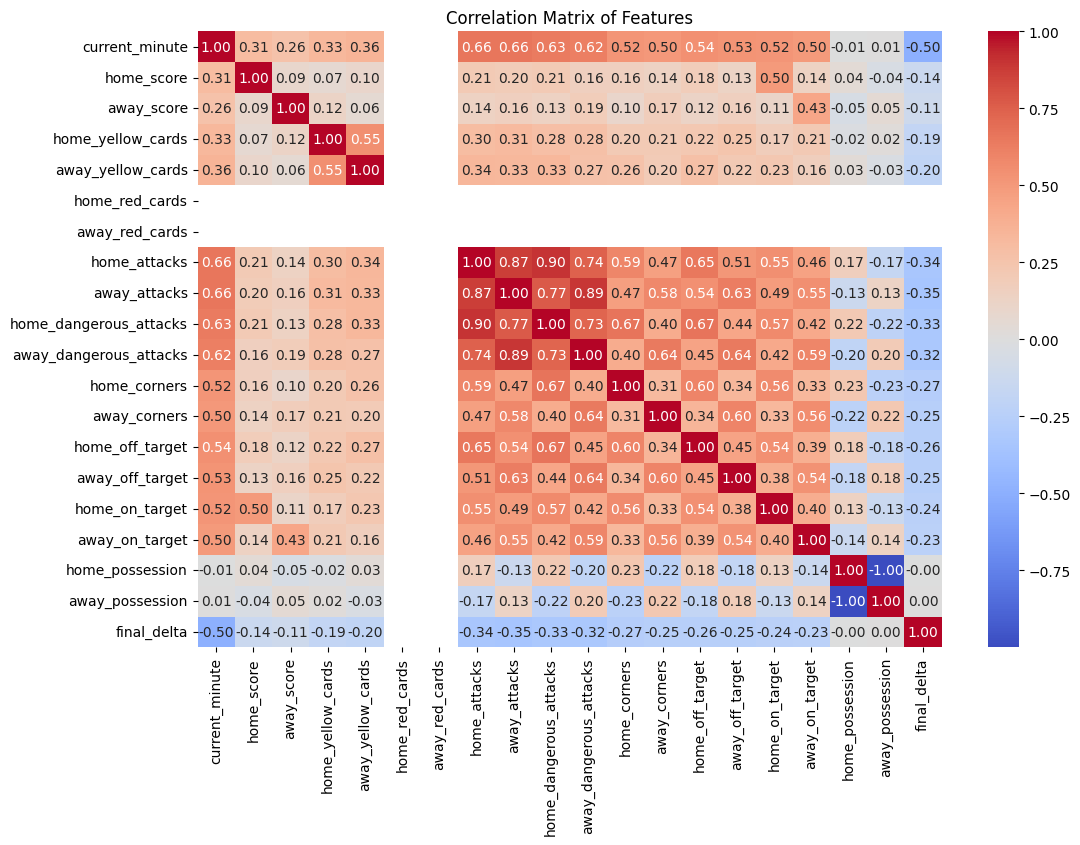

In [28]:
categorical_checks = ['home_yellow_cards', 'away_yellow_cards', 'home_red_cards', 'away_red_cards',
                      'home_score', 'away_score']

plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

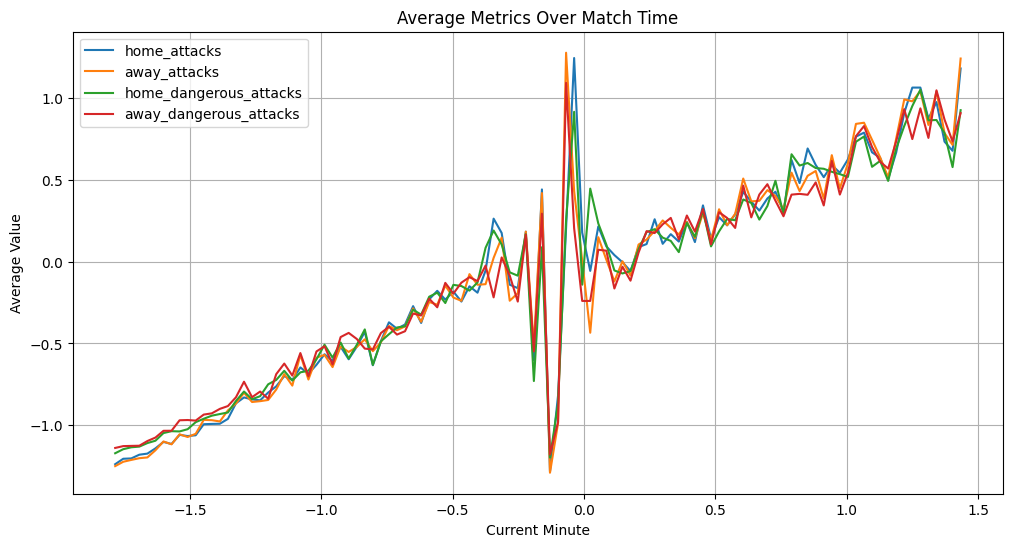

In [29]:
# Group by current_minute and calculate mean values for key metrics
time_analysis = df.groupby('current_minute').mean()
time_metrics = ['home_attacks', 'away_attacks', 'home_dangerous_attacks', 'away_dangerous_attacks']

plt.figure(figsize=(12, 6))
for metric in time_metrics:
    plt.plot(time_analysis.index, time_analysis[metric], label=metric)
plt.title("Average Metrics Over Match Time")
plt.xlabel("Current Minute")
plt.ylabel("Average Value")
plt.legend()
plt.grid()
plt.show()


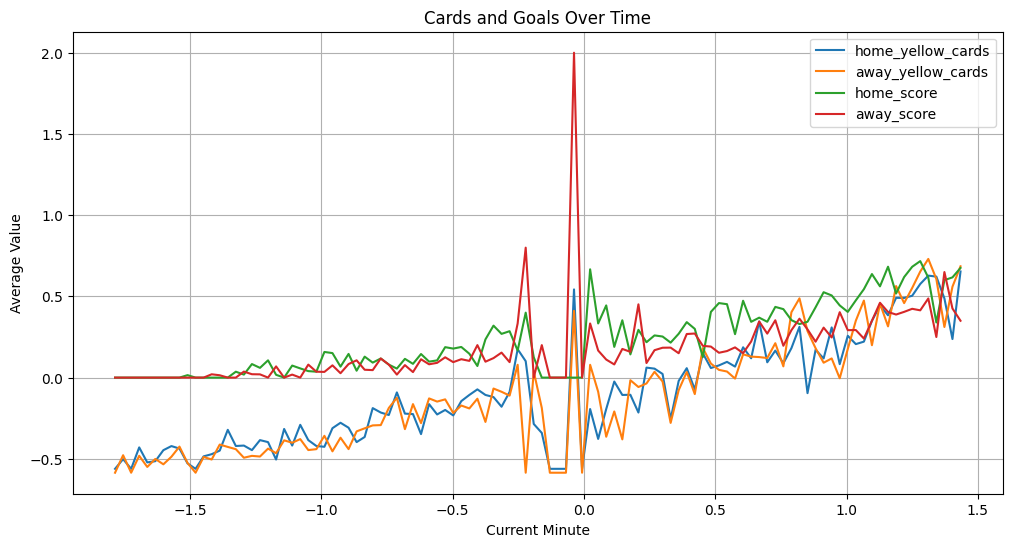

In [30]:
cards_vs_goals = ['home_yellow_cards', 'away_yellow_cards', 'home_score', 'away_score']
time_analysis[cards_vs_goals].plot(figsize=(12, 6))
plt.title("Cards and Goals Over Time")
plt.xlabel("Current Minute")
plt.ylabel("Average Value")
plt.legend()
plt.grid()
plt.show()


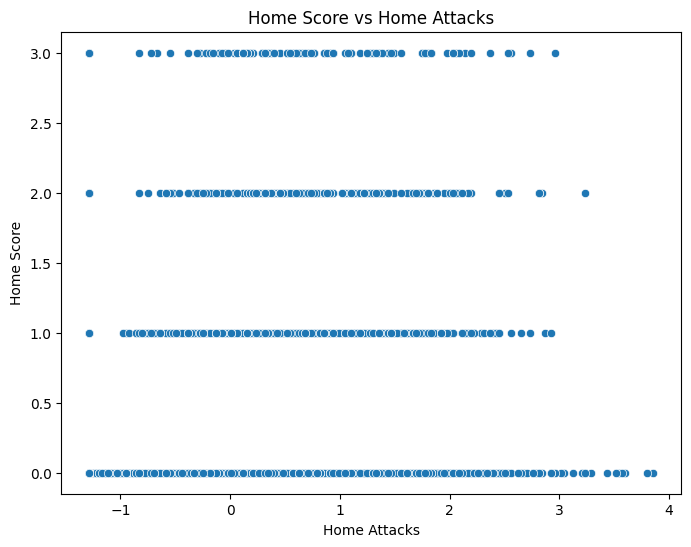

In [31]:
# Compare home_score vs. home_attacks
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='home_attacks', y='home_score')
plt.title("Home Score vs Home Attacks")
plt.xlabel("Home Attacks")
plt.ylabel("Home Score")
plt.show()

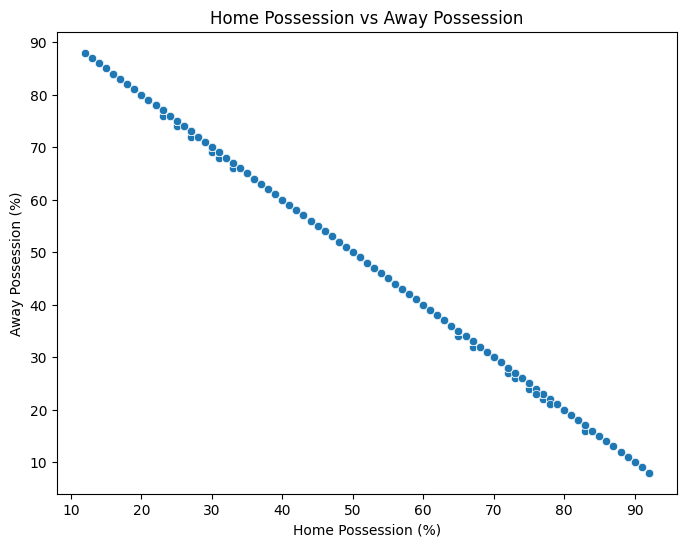

In [32]:
# Compare home_possession vs. away_possession
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='home_possession', y='away_possession')
plt.title("Home Possession vs Away Possession")
plt.xlabel("Home Possession (%)")
plt.ylabel("Away Possession (%)")
plt.show()

/var/folders/zt/18v8fdz55yz1kxfkdytd6_d40000gn/T/ipykernel_3174/3334995147.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='home_yellow_cards', y='home_score', ci=None)


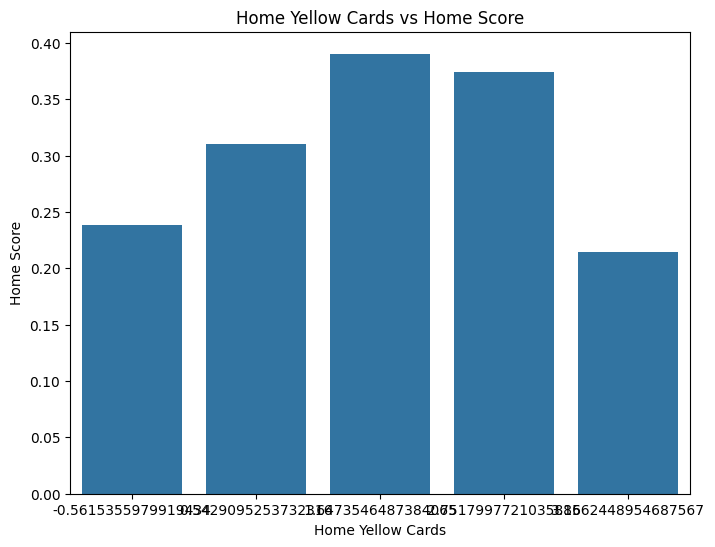

In [33]:
# Cards vs Goals
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='home_yellow_cards', y='home_score', ci=None)
plt.title("Home Yellow Cards vs Home Score")
plt.xlabel("Home Yellow Cards")
plt.ylabel("Home Score")
plt.show()

In [34]:
predictor_candidates = correlation_matrix['home_score'].sort_values(ascending=False)
print("\nPotential Predictors for Home Score:")
print(predictor_candidates)


Potential Predictors for Home Score:
home_score                1.000000
home_on_target            0.495441
current_minute            0.311090
home_attacks              0.206816
home_dangerous_attacks    0.205941
away_attacks              0.195215
home_off_target           0.184523
home_corners              0.163010
away_dangerous_attacks    0.158058
away_on_target            0.140532
away_corners              0.138300
away_off_target           0.130579
away_yellow_cards         0.098431
away_score                0.087013
home_yellow_cards         0.066676
home_possession           0.040339
away_possession          -0.040406
final_delta              -0.135580
home_red_cards                 NaN
away_red_cards                 NaN
Name: home_score, dtype: float64


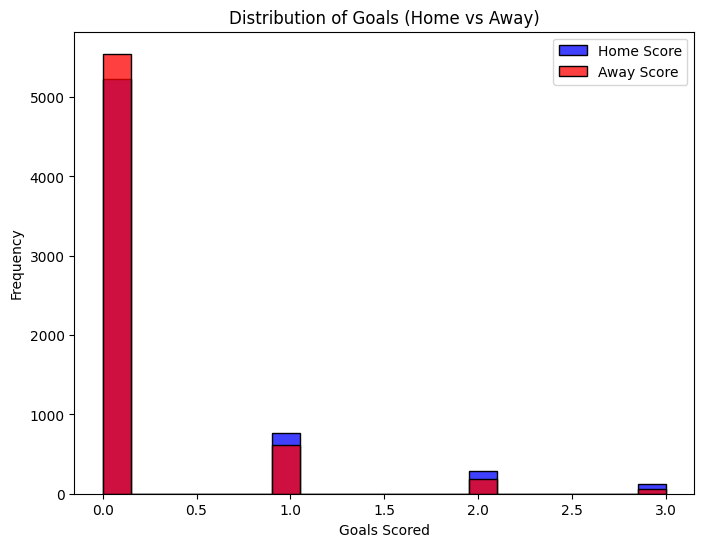

In [35]:
# Check data balance in goals
plt.figure(figsize=(8, 6))
sns.histplot(df['home_score'], kde=False, bins=20, color='blue', label='Home Score')
sns.histplot(df['away_score'], kde=False, bins=20, color='red', label='Away Score')
plt.title("Distribution of Goals (Home vs Away)")
plt.xlabel("Goals Scored")
plt.ylabel("Frequency")
plt.legend()
plt.show()

---

# **Section 6: Initial model training**

---

# **Section 7: Error analysis**

---

# **Section 8: Improving model performance**

---

# **Section 9: Model performance summary**

---

# **Section 10: Insights and conclusions**

---

# **Section 11: References**



> Dump Ref muna fix it later

https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2019.00501/full

https://www.sciencedirect.com/science/article/abs/pii/S0169207018300116

https://warin.ca/ressources/books/2013_Book_AppliedPredictiveModeling.pdf

https://ieeexplore.ieee.org/document/4160265

https://www.researchgate.net/publication/265194455_pandas_a_Foundational_Python_Library_for_Data_Analysis_and_Statistics

https://web.mit.edu/dvp/Public/numpybook.pdf

https://dl.acm.org/doi/10.5555/1953048.2078195

https://www.researchgate.net/publication/350701622_seaborn_statistical_data_visualization

https://www.sciencedirect.com/book/9780123814791/data-mining-concepts-and-techniques

https://archive.org/details/exploratorydataa0000tuke_7616

---

- Anguera, M. T., Blanco-Villaseñor, A., Losada, J. L., & Perea, M. V. (2018). Sports analysis and prediction: New challenges and approaches. Frontiers in Psychology, 10, 501. https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2019.00501/full

- Yin, D., & Leong, S. Y. (2017). Predictive modeling in soccer analytics. International Journal of Sports Management and Marketing, 7(3), 235-248. https://www.sciencedirect.com/science/article/abs/pii/S0169207018300116

- Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Springer Science & Business Media. https://warin.ca/ressources/books/2013_Book_AppliedPredictiveModeling.pdf

- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://ieeexplore.ieee.org/document/4160265

- McKinney, W. (2011). pandas: A foundational Python library for data analysis and manipulation. Python for Data Analysis, O'Reilly Media. https://www.researchgate.net/publication/265194455_pandas_a_Foundational_Python_Library_for_Data_Analysis_and_Statistics

- Oliphant, T. E. (2006). A guide to NumPy. Trelgol Publishing. https://web.mit.edu/dvp/Public/numpybook.pdf

- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://dl.acm.org/doi/10.5555/1953048.2078195

- Waskom, M. L. (2021). Seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://www.researchgate.net/publication/350701622_seaborn_statistical_data_visualization

- Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier. https://www.sciencedirect.com/book/9780123814791/data-mining-concepts-and-techniques

- Tukey, J. W. (1977). Exploratory data analysis. Addison-Wesley. https://archive.org/details/exploratorydataa0000tuke_7616